# Isometric actor cliques



In [1]:
__author__      = 'Roy Gardner'

%run ./network_functions.py


## Load the data

Loading:
- Agreement-actor signatory data including the agreement-actor biadjacency matrix.
- Mediation event-actor data including the event-actor biadjacency matrix.


In [2]:
data_path = '../paax_data/v8/'

# Actor data in this file
actors_file = 'paax_actor_table.csv'

# Links agreements to actors and define status as party/third-party
signatories_file = 'paax_signatories_v8.csv'

# PAX agreements database dump
agreements_file = 'pax.csv'

# Relationship of agreement to country
countries_file = 'pax_v8_id_to_con_info.csv'

data_dict = load_agreement_actor_data(actors_file,signatories_file,agreements_file,countries_file,data_path)

# Map PA-X actor IDs onto agreement actor IDs
pax_actor_dict = {v['id']:k for k,v in data_dict['actors_dict'].items()}



## Agreement space

Actor-actor matrix in agreement space for the Sudan Transition Process.


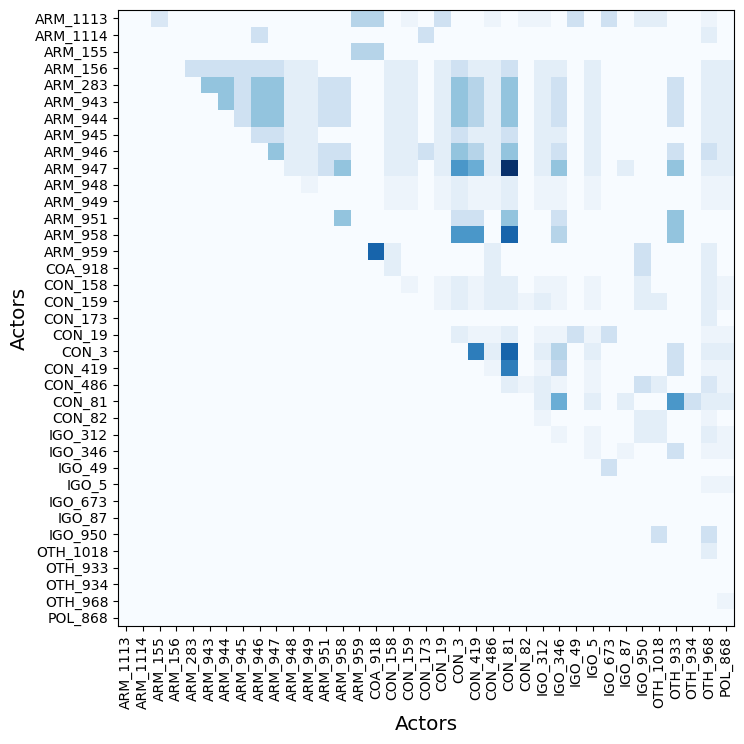

In [306]:
process_name = 'Sudan Transition Process'

pp_data_dict = get_peace_process_data(process_name,data_dict)
pp_matrix = pp_data_dict['matrix']

actor_upper = np.triu(np.matmul(pp_matrix.T,pp_matrix),k=1)

f = plt.figure(figsize=(8,8))
plt.imshow(actor_upper,cmap=plt.cm.Blues)
plt.xticks(range(0,len(pp_data_dict['actor_ids'])),pp_data_dict['actor_ids'],rotation=90)
plt.yticks(range(0,len(pp_data_dict['actor_ids'])),pp_data_dict['actor_ids'])
plt.xlabel('Actors',fontsize='x-large')
plt.ylabel('Actors',fontsize='x-large')
plt.show()



## Find isometric actor cliques in agreement space

Agreement space aka the co-occurrence matrix. Isometry means ranking cliques of actors by the cardinality of the intersection of their agreement sets, i.e., the number of agreements the actors have in common

### TODO

- Apply superimposition to ranking cliques.
- Clique enumeration is too slow in networkx. 



Ranks: [3, 0, 1, 2, 4]
Clique size: 3
Rank: 3


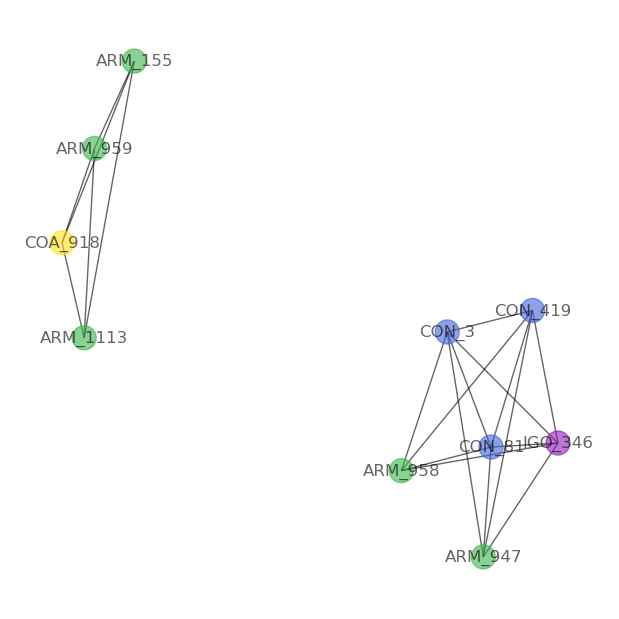

In [321]:
process_name = 'Sudan Transition Process'

# Going for triangles
clique_size = 3

# Get the peace process data dictionary
pp_data_dict = get_peace_process_data(process_name,data_dict)

# Binarise the matrix which means we are ignoring party/third party which is an integer coding
# in the edge weight property
pp_matrix = (pp_data_dict['matrix'] > 0).astype(np.int64)

# Get the actor-actor co-occurence matrix
actor_upper = np.triu(np.matmul(pp_matrix.T,pp_matrix),k=1)

# Convert to networkx so we can finf cliques
graph = nx.from_numpy_array(actor_upper, create_using=nx.Graph)
cliques = nx.enumerate_all_cliques(graph)

cliques = [x for x in cliques if len(x)==clique_size]    


# Compute the clique ranks = cardinality of intersections of the actor agreement sets in a clique. 
# This is the number of agreements the clique actors have in common.
clique_ranks = {}
for i,c in enumerate(cliques):
    labels = [pp_data_dict['actor_ids'][actor_index] for actor_index in c]
    agreement_vectors = [pp_matrix[:,actor_index] for actor_index in c]
    
    # Compute the resultant matrix
    bitset = agreement_vectors[0]
    for i,vector in enumerate(agreement_vectors):
        bitset = np.bitwise_and(bitset,vector)
    
    rank = len([v for v in bitset if v==1])
    if rank in clique_ranks:
        clique_ranks[rank].append(labels)
    else:
        clique_ranks[rank] = [labels]
        
print()
print('Ranks:',list(clique_ranks.keys()))

# Get clique submatrix for a given rank and visualise as network
rank = 3

clique_ids = []
for clique in clique_ranks[rank]:
    clique_ids.extend(clique)

clique_ids = list(set(clique_ids))


adj_matrix = actor_upper.copy()

actor_indices = [pp_data_dict['actor_ids'].index(clique_id) for clique_id in clique_ids]
adj_matrix = adj_matrix[np.ix_(actor_indices,actor_indices)]
# Threshold the matrix
adj_matrix[adj_matrix < rank] = 0
node_labels = {i:pp_data_dict['actor_ids'][index] for i,index in enumerate(actor_indices)}
node_colors = [data_dict['color_map'][v.split('_')[0]] for _,v in node_labels.items()]

f = plt.figure(figsize=(6,6))
# Generate the graph and get the weights
graph = nx.from_numpy_array(adj_matrix, create_using=nx.Graph) 

print('Clique size:',clique_size)
print('Rank:',rank)

nx.draw(
    graph,
    pos=nx.spring_layout(graph, scale=80,k=2),
    labels=node_labels,
    node_color=node_colors,
    with_labels=True,
    alpha=0.6
)
plt.show()
